In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_theme()

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [2]:
# create datasets
def generate_in_distribution_data(n, mu, sigma, pi_in):
    n_1 = int(n*pi_in)
    n_0 = int(n*(1-pi_in))
    mu_1 = mu
    mu_0 = -mu_1
    X_0 = np.random.normal(mu_0, sigma, n_0)
    X_1 = np.random.normal(mu_1, sigma, n_1)
    X = np.concatenate((X_0, X_1))
    Y = np.concatenate((np.zeros(n_0), np.ones(n_1)))
    return X, Y

def generate_out_distribution_data(n, mu, sigma, pi_out, delta):
    n_1 = int(n*pi_out)
    n_0 = int(n*(1-pi_out))
    mu_1 = mu + delta
    mu_0 = -mu + delta
    X_0 = np.random.normal(mu_0, sigma, n_0)
    X_1 = np.random.normal(mu_1, sigma, n_1)
    X = np.concatenate((X_0, X_1))
    Y = np.concatenate((np.zeros(n_0), np.ones(n_1)))
    return X, Y

## Single-Head LDA

Consinder a univariate binary classification task with normal distributions as class condtional densities $f_0$ and $f_1$, parameterized by $(\mu_0, \sigma^2)$ and $(\mu_1, \sigma^2)$. If the class 1 prior probability is $\pi$, the Baye's decision rule for this problem is given by,

$$
g(x) = 
    \begin{cases}
        1 & \pi f_1 > (1-\pi)f_0 \\
        0 & \text{otherwise}
    \end{cases}
$$

It can be shown that this decision rule can be written in terms of the above parameters as below.

$$
g(x) = 
    \begin{cases}
        1 & x > \frac{\mu_0 + \mu_1}{2} + \frac{\sigma^2}{\mu_1 - \mu_0} \log \frac{1-\pi}{\pi} \\
        0 & \text{otherwise}
    \end{cases}
$$

When class priors are equal, the decision rule is simply:

$$
g(x) = 
    \begin{cases}
        1 & x > \frac{\mu_0 + \mu_1}{2}\\
        0 & \text{otherwise}
    \end{cases}
$$

In terms of estimates, the threshold can be written as, 

$$ c = \frac{\bar{X}_0 + \bar{X}_1}{2} $$

In the single-head model, we feed both target and OOD data (both of which have the same label distribution) into the algorithm. Thus, $\bar{X}_0, \bar{X}_1$ are estimated using both target and OOD data. 


In [41]:
def compute_singlehead_decision_rule(X_in, Y_in, X_out, Y_out):

    X = np.concatenate((X_in, X_out))
    Y = np.concatenate((Y_in, Y_out))

    X_0 = X[Y == 0]
    X_0_bar = np.mean(X_0)

    X_1 = X[Y == 1]
    X_1_bar = np.mean(X_1)

    # estimate threshold
    c = (X_1_bar + X_0_bar)/2
    
    return c

def compute_empirical_risk(X, Y, c):
    Y_pred = (X > c).astype('int')
    risk = 1 - np.mean(Y_pred == Y)
    return risk

def run_simulation(
    n = 4,
    n_test = 500,
    mu = 1,
    sigma = 1,
    pi_in = 0.5,
    pi_out = 0.5,
    Delta = [0, 0.2, 0.5, 0.8, 1, 1.5, 2],
    m_sizes = np.arange(0, 21, 1),
    reps = 1000,
):
    X_test, y_test = generate_in_distribution_data(n_test, mu, sigma, pi_in)

    df = pd.DataFrame()
    
    i = 0
    for m in m_sizes:
        for r, rep in enumerate(range(reps)):
            df.at[i, "m"] = m
            df.at[i, "r"] = r
            X_in, Y_in = generate_in_distribution_data(n, mu, sigma, pi_in)
            
            for delta in Delta:
                X_out, Y_out = generate_out_distribution_data(m, mu, sigma, pi_out, delta)
                c = compute_singlehead_decision_rule(X_in, Y_in, X_out, Y_out)
                df.at[i, str(delta)] = compute_empirical_risk(X_test, y_test, c)
            i+=1
    
    dfm = df.melt(['m', 'r'], var_name='Delta', value_name='Risk')
    fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')
    ax = sns.lineplot(data=dfm, x="m", y="Risk", hue="Delta", ax=ax, markers=True, ci=95, lw=2)
    ax.set_ylabel("Expected Risk")
    ax.set_xlabel(r"$m/n, n={}$".format(n))
    # ax.set_xlim([0, 100])
    return df

### Simulations

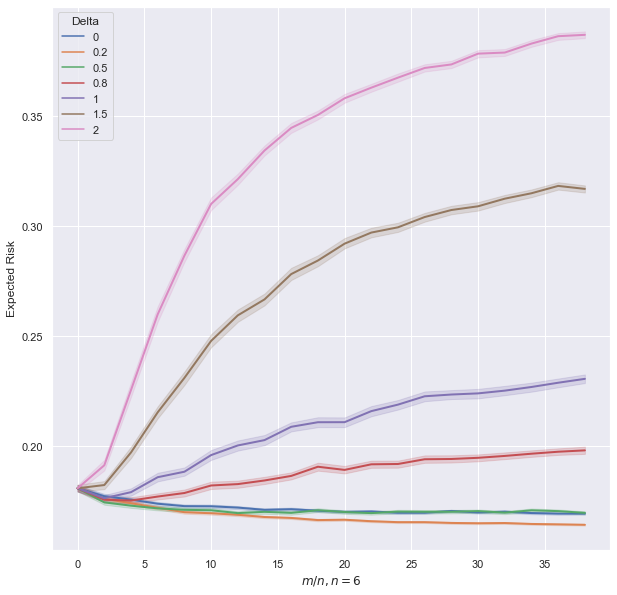

In [43]:
df = run_simulation(
    n = 6,
    n_test = 500,
    mu = 1,
    sigma = 1,
    pi_in = 0.5,
    pi_out = 0.5,
    Delta = [0, 0.2, 0.5, 0.8, 1, 1.5, 2],
    m_sizes = np.arange(0, 40, 2),
    reps = 1000,
)

### Theoretical Analysis

#### Analytical Computed Expected Risk Curves

In [69]:
def expected_risk(n, m, delta):
    mu_h = (m/(n+m))*delta
    sigma_h = np.sqrt(3/(n+m))
    risk = 0.5*(1 + norm.cdf((mu_h - 1)/(np.sqrt(1 + sigma_h**2))) - norm.cdf((mu_h + 1)/(np.sqrt(1 + sigma_h**2))))
    return risk

Text(0.5, 0, '$m/n, n=6$')

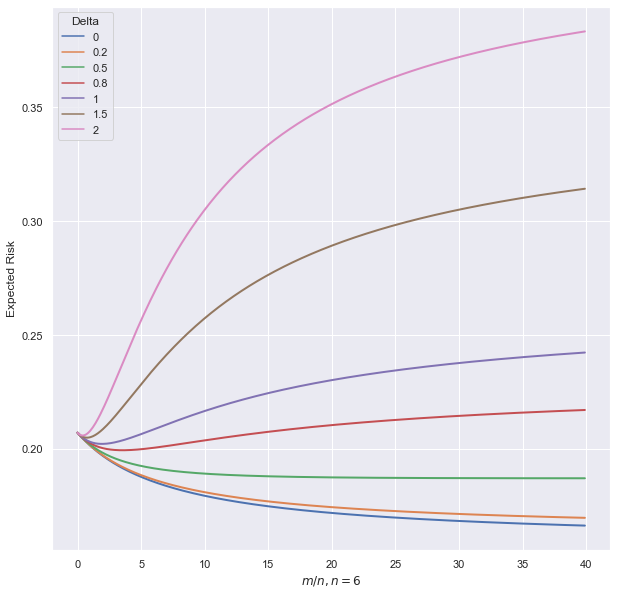

In [74]:
n = 6
m_sizes = np.arange(0, 40, 0.1)
Delta = [0, 0.2, 0.5, 0.8, 1, 1.5, 2]
i = 0
df = pd.DataFrame()
for m in m_sizes:
    df.at[i, "m"] = m
    for delta in Delta:
        df.at[i, str(delta)] = expected_risk(n, m, delta)
    i+=1

dfm = df.melt(['m'], var_name='Delta', value_name='Risk')
fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')
ax = sns.lineplot(data=dfm, x="m", y="Risk", hue="Delta", ax=ax, markers=True, ci=95, lw=2)
ax.set_ylabel("Expected Risk")
ax.set_xlabel(r"$m/n, n={}$".format(n))
# ax.set_xlim([0, 100])


#### Optimal OOD Sample Size Curves across $n$ and $\Delta$

In [84]:
n_sizes = np.arange(4, 20, 1)
m_sizes = np.arange(0, 100, 0.1)
Delta = np.arange(0, 2, 0.01)

df = pd.DataFrame()
dict = {}
for n in n_sizes:
    m_opt = []
    for delta in Delta:
        risk_vals = [expected_risk(n, m, delta) for m in m_sizes]
        m_opt.append(m_sizes[np.argmin(risk_vals)])
    dict[str(n)] = m_opt

df = pd.DataFrame.from_dict(dict)
df['Delta'] = Delta

Text(0.5, 0, '$\\Delta$')

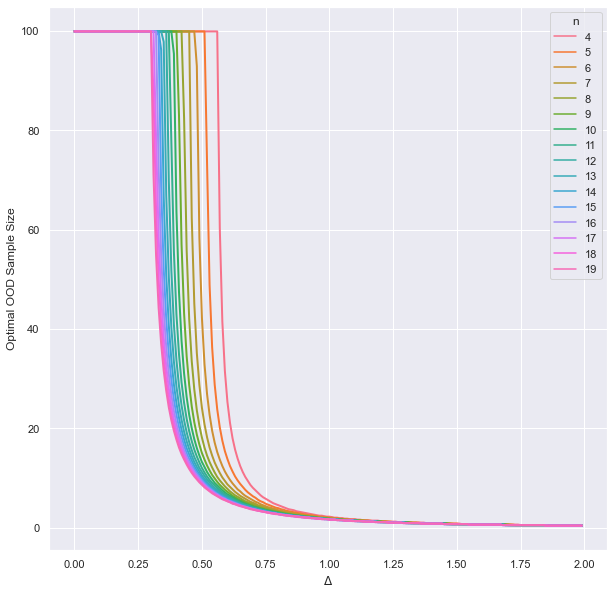

In [103]:
dfm = df.melt(['Delta'], var_name='n', value_name='m_opt')
fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')
ax = sns.lineplot(data=dfm, x='Delta', y='m_opt', hue='n', ax=ax, lw=2)
ax.set_ylabel("Optimal OOD Sample Size")
ax.set_xlabel(r"$\Delta$")

### Training with $\alpha$-Weighting

Let $D_{in} : \{ X_i, Y_i \}_{i=1}^n \stackrel{iid}{\sim} \mathcal{P}_t$ and $D_{out} : \{ X_i, Y_i \}_{i=1}^m \stackrel{iid}{\sim} \mathcal{P}_o$, where $\mathcal{P}_o$ is characterised by $X|Y=y \sim \mathcal{N}(\mu_0 - (-1)^y, 1), \; Y \sim \text{Bern}(0.5)$ and $\mathcal{P}_o$ is characterised by  $X|Y=y \sim \mathcal{N}(\mu_0 + \Delta - (-1)^y, 1), \; Y \sim \text{Bern}(0.5)$. We are interested in improving an FLD's generalization error on the target task using data from both the target and OOD tasks. The FLD decision rule for the target task is given by, 
$$
\begin{equation}
        h(x) = 
        \begin{cases}
            1 & x > \mu_0 \\
            0 & \text{otherwise}
        \end{cases}
\end{equation}
$$
The likelihood function for $\mu_0$ can be written as follows. 
$$
\begin{equation}
    L(\mu_0) = f_{XY}((x_1, y_1), \dots, (x_n, y_n))^{\alpha} f_{XY}((x_1, y_1), \dots, (x_m, y_m))^{1-\alpha} 
\end{equation}
$$
where $\alpha$ denotes the weighting coefficient and $f_{XY}$ is given by,
$$
\begin{equation}
    f_{XY}(x,y) = f_{X|Y}(x|y)f_Y(y) = \frac{1}{\sqrt{2\pi}} \exp \bigg[ -\frac{1}{2} (x - \mu_0 + (-1)^y)^2 \bigg] 0.5^y (0.5)^{1-y}
\end{equation}
$$
Maximizing the $L(\mu_0)$, we arrive at the maximum likelihood estimator for $\mu_0$ (proof omitted), 
$$
\begin{equation}
    \hat{\mu}_0 = \frac{\alpha \sum_{i=1}^n (X_i + (-1)^{Y_i}) + (1-\alpha) \sum_{j=1}^m (X_j + (-1)^{Y_j})}{\alpha n + (1-\alpha)m}
\end{equation}
$$
The expected value and variance of $\hat{\mu}_0$ are respectively given by (proof omitted), 
$$
\begin{equation}
    \mu_h = \mathbb{E}[\hat{\mu}_0] = \mu_0 + \frac{(1-\alpha)m}{\alpha n + (1-\alpha)m} \Delta \sigma
\end{equation}
$$
$$
\begin{equation}
        \sigma_h^2 = \text{Var}[\hat{\mu}_0] = 3 \bigg[ \frac{\alpha^2 n + (1-\alpha)^2 m}{(\alpha n + (1-\alpha)m)^2} \bigg]
\end{equation}
$$
Therefore, assuming $\mu_0 = 0$, the expected risk for this problem is given by,
$$
\begin{equation}
\mathcal{E}_t(h) = \frac{1}{2}\bigg[ 1 + \Phi \bigg( \frac{\mu_h - 1}{\sqrt{1 + \sigma_h^2}} \bigg)  - \Phi \bigg( \frac{\mu_h + 1}{\sqrt{1 + \sigma_h^2}} \bigg)\bigg]
\end{equation}
$$

In [106]:
def expected_risk(n, m, alpha, delta):
    mu_h = ((1-alpha)*m/(alpha*n + (1-alpha)*m))*delta
    sigma_h = np.sqrt(3*(alpha**2*n + (1-alpha)**2*m)/(alpha*n + (1-alpha)*m)**2)
    risk = 0.5*(1 + norm.cdf((mu_h - 1)/(np.sqrt(1 + sigma_h**2))) - norm.cdf((mu_h + 1)/(np.sqrt(1 + sigma_h**2))))
    return risk

In [119]:
n = 6
m_sizes = np.arange(3, 40, 0.1)
delta = 0.8
alpha_range = np.arange(0, 1.2, 0.2)
i = 0
df = pd.DataFrame()
for m in m_sizes:
    df.at[i, "m"] = m
    for alpha in alpha_range:
        df.at[i, str(alpha)] = 1 - expected_risk(n, m, alpha, delta)
    i+=1

Text(0.5, 0, '$m/n, n=6$')

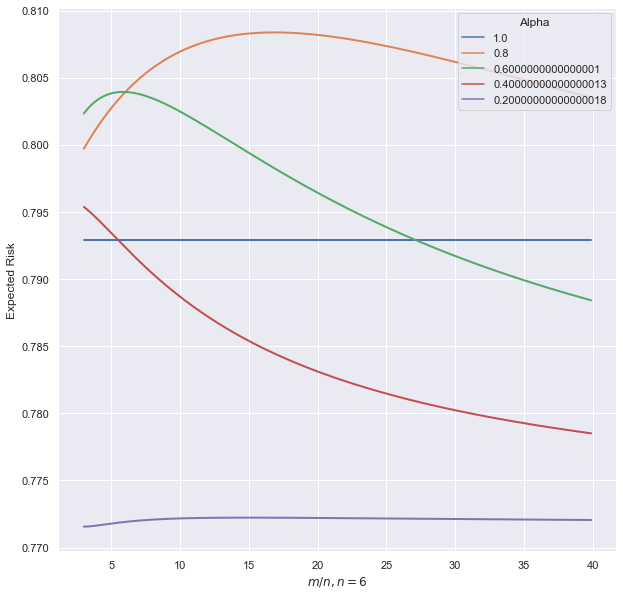

In [120]:
dfm = df.melt(['m'], var_name='Alpha', value_name='Risk')
fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')
ax = sns.lineplot(data=dfm, x="m", y="Risk", hue="Alpha", ax=ax, markers=True, ci=95, lw=2)
ax.set_ylabel("Expected Risk")
ax.set_xlabel(r"$m/n, n={}$".format(n))
# ax.set_xlim([0, 100])

## Multi-Head LDA

In [73]:
def compute_multihead_decision_rule(X_in, Y_in, X_out, Y_out):

    X = np.concatenate((X_in, X_out))
    Y = np.concatenate((Y_in, Y_out))
    X_1 = X[Y==1]
    X_0 = X[Y==0]
    X_1_bar = np.mean(X_1)
    X_0_bar = np.mean(X_0)

    X_in_0 = X_in[Y_in==0]
    X_in_0_bar = np.mean(X_in_0)
    X_centered = X_in_0 - X_in_0_bar
    S_w_in_0 = np.sum(X_centered**2)

    X_in_1 = X_in[Y_in==1]
    X_in_1_bar = np.mean(X_in_1)
    X_centered = X_in_1 - X_in_1_bar
    S_w_in_1 = np.sum(X_centered**2)

    X_out_0 = X_out[Y_out==0]
    X_out_0_bar = np.mean(X_out_0)
    X_centered = X_out_0 - X_out_0_bar
    S_w_out_0 = np.sum(X_centered**2)

    X_out_1 = X_out[Y_out==1]
    X_out_1_bar = np.mean(X_out_1)
    X_centered = X_out_1 - X_out_1_bar
    S_w_out_1 = np.sum(X_centered**2)

    S_w = (S_w_in_0 + S_w_in_1 + S_w_out_0 + S_w_out_1)/len(Y)

    # estimate projection term
    omega = (X_1_bar - X_0_bar)/S_w

    # estimate target priors
    p_in = len(Y_in[Y_in==1])/len(Y_in)

    # estimate threshold
    h = (X_in_1_bar + X_in_0_bar)/2 + (1/omega)*np.log((1-p_in)/p_in)
    
    return h

def compute_empirical_risk(X, Y, h):
    Y_pred = (X > h).astype('int')
    risk = 1 - np.mean(Y_pred == Y)
    return risk

def run_simulation(
    n = 4,
    n_test = 500,
    mu = 1,
    sigma = 1,
    pi_in = 0.5,
    pi_out = 0.5,
    Delta = [0, 0.2, 0.5, 0.8, 1, 1.5, 2],
    m_sizes = np.arange(0, 21, 1),
    reps = 1000,
):
    X_test, y_test = generate_in_distribution_data(n_test, mu, sigma, pi_in)

    df = pd.DataFrame()
    
    i = 0
    for m in m_sizes:
        for r, rep in enumerate(range(reps)):
            df.at[i, "m"] = m
            df.at[i, "r"] = r
            X_in, Y_in = generate_in_distribution_data(n, mu, sigma, pi_in)
            
            for delta in Delta:
                X_out, Y_out = generate_out_distribution_data(m, mu, sigma, pi_out, delta)
                c = compute_multihead_decision_rule(X_in, Y_in, X_out, Y_out)
                df.at[i, str(delta)] = compute_empirical_risk(X_test, y_test, c)
            i+=1
    
    dfm = df.melt(['m', 'r'], var_name='Delta', value_name='Risk')
    fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')
    ax = sns.lineplot(data=dfm, x="m", y="Risk", hue="Delta", ax=ax, markers=True, ci=95, lw=2)
    ax.set_ylabel("Expected Risk")
    ax.set_xlabel(r"$m/n, n={}$".format(n))
    # ax.set_xlim([0, 100])
    return df

$p_{in} = p_{out} = 0.6$

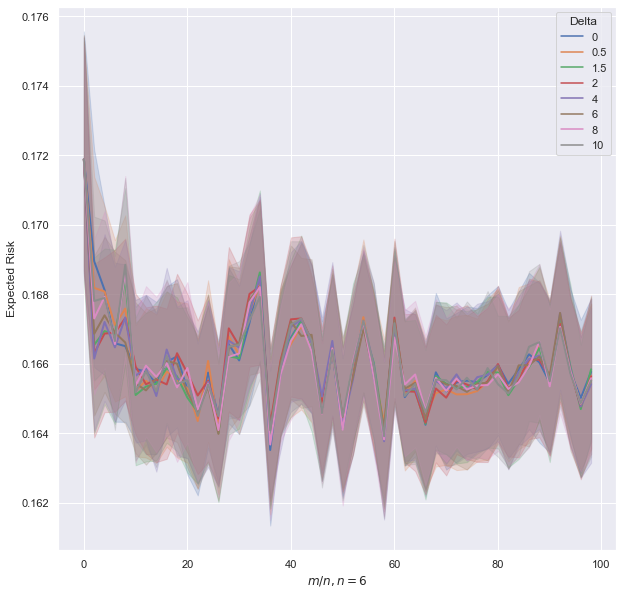

In [78]:
df = run_simulation(
    n = 6,
    n_test = 500,
    mu = 1,
    sigma = 1,
    pi_in = 0.6,
    pi_out = 0.6,
    Delta = [0, 0.5, 1.5, 2, 4, 6, 8, 10],
    m_sizes = np.arange(0, 100, 2),
    reps = 1000,
)

$p_{in} = p_{out} = 0.8$

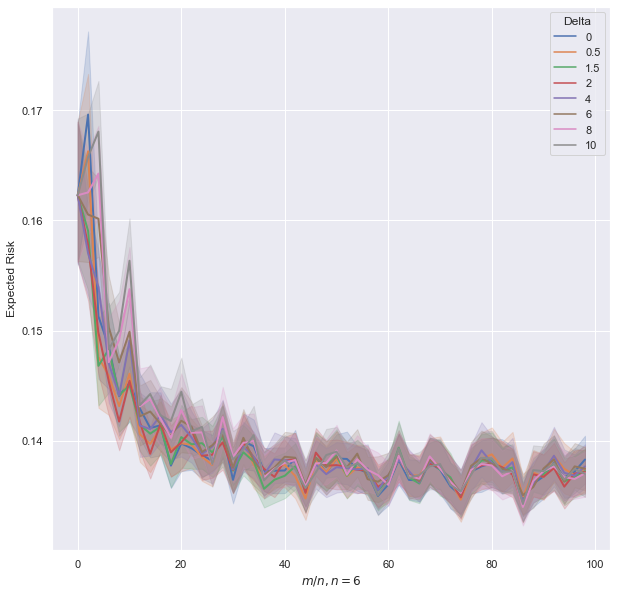

In [80]:
df = run_simulation(
    n = 6,
    n_test = 500,
    mu = 1,
    sigma = 1,
    pi_in = 0.8,
    pi_out = 0.8,
    Delta = [0, 0.5, 1.5, 2, 4, 6, 8, 10],
    m_sizes = np.arange(0, 100, 2),
    reps = 1000,
)

$p_{in} = 0.6,  p_{out} = 0.3$

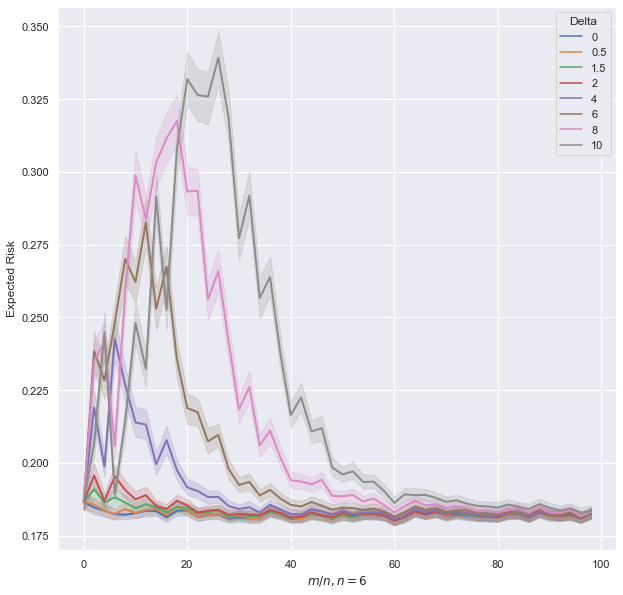

In [81]:
df = run_simulation(
    n = 6,
    n_test = 500,
    mu = 1,
    sigma = 1,
    pi_in = 0.6,
    pi_out = 0.3,
    Delta = [0, 0.5, 1.5, 2, 4, 6, 8, 10],
    m_sizes = np.arange(0, 100, 2),
    reps = 1000,
)

$p_{in} = 0.7, p_{out} = 0.4$

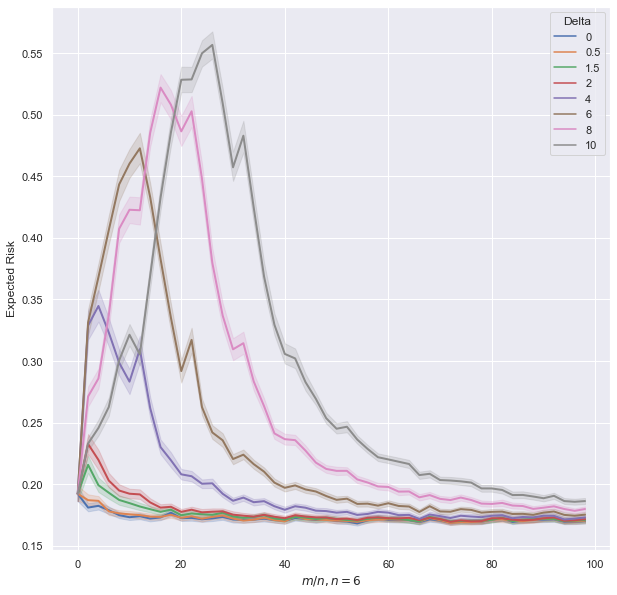

In [82]:
df = run_simulation(
    n = 6,
    n_test = 500,
    mu = 1,
    sigma = 1,
    pi_in = 0.7,
    pi_out = 0.4,
    Delta = [0, 0.5, 1.5, 2, 4, 6, 8, 10],
    m_sizes = np.arange(0, 100, 2),
    reps = 1000,
)

$p_{in} = 0.8, p_{out} = 0.6$

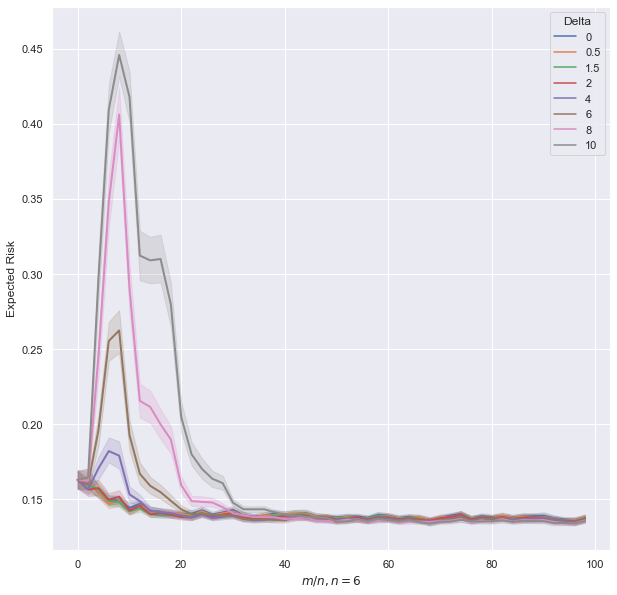

In [83]:
df = run_simulation(
    n = 6,
    n_test = 500,
    mu = 1,
    sigma = 1,
    pi_in = 0.8,
    pi_out = 0.6,
    Delta = [0, 0.5, 1.5, 2, 4, 6, 8, 10],
    m_sizes = np.arange(0, 100, 2),
    reps = 1000,
)